# MFE230T

## Jen-Chieh Cheng

In [1]:
import json
import gensim
import nltk
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import string

In [2]:
df = pd.read_csv('./data/Reviews.csv')

### Understanding the data

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Remove missing values, duplicated date, parse text...

In [5]:
df_clean = df.drop_duplicates('Text').dropna()

print df_clean.shape

(393566, 10)


In [8]:
LOWER_SPACE = string.lowercase + ' '
en_stopwords = stopwords.words('english')

def text_parser(text):
    cleaned = BeautifulSoup(text, 'lxml').text
    cleaned = cleaned.lower().replace('\n',' ').replace('\t', ' ')
    
    for char in string.punctuation:
        cleaned = cleaned.replace(char,' ')
    cleaned = filter(lambda char: char in LOWER_SPACE, cleaned)
    cleaned = ' '.join(filter(lambda s: s not in en_stopwords, cleaned.split()))
    return str(cleaned)

In [9]:
print 'BEFORE:\n', df_clean.Text[999] 
print 'AFTER:\n', text_parser(df_clean.Text[999])

BEFORE:
I have to admit, I was a sucker for the large quantity, 12 oz, when shopping for hot sauces ...but now seeing the size of the bottle, it reminds of wing-sauce bottle sizes.  Plastic bottle.  It does have a convenient squirt top.  But overall, not very hot or tasty, and made mostly from jalape&ntilde;os.  If I had seen the ingredients list I would not have bought it:<br />Jalapenos<br />Water<br />Vinegar<br />Brown Sugar<br />Lime Juice<br />Fish Sauce<br />Cilantro<br />Habanero<br />Garlic<br />Spice Blend<br />Salt<br />Potassium Sorbate<br />Xanthan Gum
AFTER:
admit sucker large quantity oz shopping hot sauces seeing size bottle reminds wing sauce bottle sizes plastic bottle convenient squirt top overall hot tasty made mostly jalapeos seen ingredients list would bought jalapenoswatervinegarbrown sugarlime juicefish saucecilantrohabanerogarlicspice blendsaltpotassium sorbatexanthan gum


In [10]:
df_clean['Text'] = df_clean['Text'].apply(text_parser)

### Word cloud

In [11]:
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

stopwords = set(STOPWORDS)

mpl.rcParams['font.size']=12                 
mpl.rcParams['savefig.dpi']=100              
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

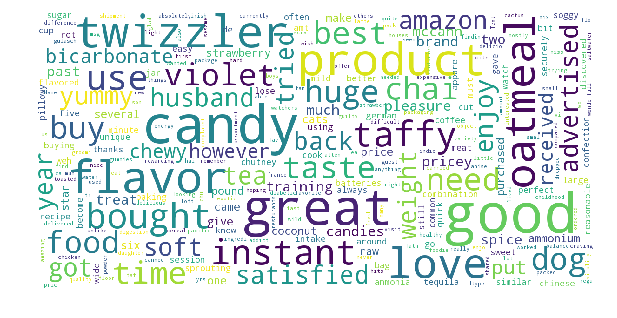

In [12]:
show_wordcloud(df_clean[df_clean['Score']>3].Text)

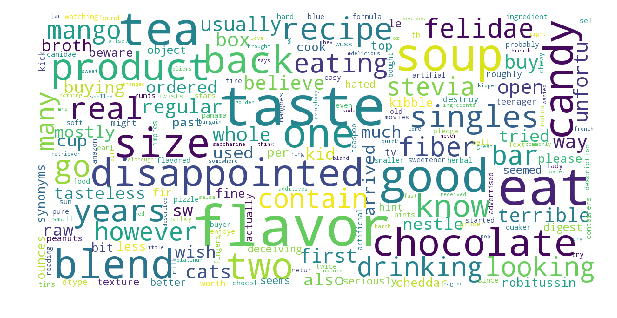

In [13]:
show_wordcloud(df_clean[df_clean['Score']<3].Text)

### Review rating in the dataset

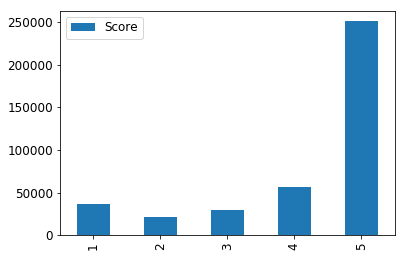

In [16]:
hist = pd.cut(df_clean['Score'], 5, labels=[1,2,3,4,5]).value_counts(sort=False)
hist.to_frame().plot.bar()

### Word frequency across all reviews

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

word_vectorizer = CountVectorizer(analyzer='word', stop_words='english',min_df=2)
sparse_matrix = word_vectorizer.fit_transform(df_clean['Text'])
frequencies = sum(sparse_matrix).toarray()[0]
words = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
print words.describe()
words.head(10)

           frequency
count   58546.000000
mean      229.435401
std      2164.029436
min         2.000000
25%         3.000000
50%         7.000000
75%        30.000000
max    173355.000000


,frequency
aa,107
aaa,42
aaaa,9
aaaaa,10
aaaaaa,2
aaaaaah,2
aaaaah,2
aaaah,3
aaaahhhhhh,2
aaaand,2


In [18]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

### Topic extraction with LDA

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

n_features = 1000
n_components = 10
n_top_words = 25

vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=n_features, stop_words='english')
tfidf = vectorizer.fit_transform(df_clean.Text)
feature_names = vectorizer.get_feature_names()

#print feature_names
lda = LatentDirichletAllocation(n_components=n_components, learning_method='online')
lda.fit(tfidf)
print("\nTopics in LDA model:")
print_top_words(lda, feature_names, n_top_words)


Topics in LDA model:
Topic #0: coffee tea cup cups flavor strong green roast good like beans drink decaf blend taste great bitter smooth starbucks coffees best love keurig brew pods
Topic #1: like taste flavor water good tea sugar drink product great use chocolate milk really sweet hot bottle love little tastes vanilla tried make dark try
Topic #2: amazon price product order arrived great stores store shipping local grocery buy thanks delivery purchase fast good ordered time love online cans available happy item
Topic #3: nuts machine highly yummy christmas seeds chews recommended year peanuts old loves gift daughter maple dried jelly recommend needed hazelnut beverage amazing save family raisins
Topic #4: sauce bread butter soup pasta rice use oil chicken peanut add great easy make mix noodles cook good cooking olive hot seasoning like spicy meal
Topic #5: dog food dogs treats loves treat beef eat love chicken jerky canned tuna vet dressing picky puppy great friend like giving bones 

### Checking the distribution of topics over reviews

In [20]:
topic_distrib = lda.transform(tfidf[0])
print df_clean.iloc[0].Text, df_clean.iloc[0].Score

bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better 5


In [21]:
print topic_distrib
print "topics ordered:", np.argsort(topic_distrib[0])[::-1][:]

[[ 0.02174686  0.0217456   0.02174564  0.02174124  0.02174473  0.3223398
   0.38604598  0.0217437   0.0217398   0.13940665]]
topics ordered: [6 5 9 0 2 1 4 7 3 8]


In [22]:
topic_distrib = lda.transform(tfidf[11])
print df_clean.iloc[11].Text, df_clean.iloc[11].Score

one boys needed lose weight put food floor chubby guy protein rich product food higher skinny boy jump higher food sits going stale really go food chubby boy losing ounce week 5


In [23]:
print topic_distrib
print "topics ordered:", np.argsort(topic_distrib[0])[::-1][:]

[[ 0.02467147  0.02463326  0.02461892  0.14670976  0.02461905  0.27250854
   0.40836757  0.02462209  0.02461689  0.02463246]]
topics ordered: [6 5 3 0 1 9 7 4 2 8]


### Create Labels abd Fetures

 - Label: Positive and Negative only
 - Feture: train LDA focus on positive / negative sentiment

In [29]:
flitered_df = df_clean[df_clean.Score != 3]
print flitered_df.shape
y = flitered_df.Score.map({1: -1, 2: -1, 4: 1, 5: 1})

(363813, 10)


In [28]:
flitered_tfidf = vectorizer.transform(flitered_df)
flitered_tfidf.shape

(10, 1000)

In [35]:
flitered_vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, max_features=1500, stop_words='english')
flitered_tfidf = flitered_vectorizer.fit_transform(flitered_df.Text)
feature_names = flitered_vectorizer.get_feature_names()

flitered_lda = LatentDirichletAllocation(n_components=15, learning_method='online')
flitered_lda.fit(flitered_tfidf)
print("\nTopics in LDA model:")
print_top_words(flitered_lda, feature_names, n_top_words=25)


Topics in LDA model:
Topic #0: baby son formula daughter loves stale gift satisfy impossible birthday likes sardines th bother dates burn worried scoop earth old present vegetables run touch loved
Topic #1: machine stevia honey seeds priced receive latte recipes peanuts flowers vendor difference jasmine reasonably raw cappuccino fabulous crazy quaker office golden allergy mother super overpowering
Topic #2: dog food dogs treats cat cats loves treat eat love old vet dry pet chew chews picky issues chicken feed puppy small bones eats healthy
Topic #3: coffee cup roast decaf strong flavor coffees beans blend pods smooth dark morning keurig french bitter like taste good popcorn best great bean senseo tried
Topic #4: tea teas green drink flavor chai cups taste iced rich black cup drinking love like good great strong lemon bags wine grey refreshing favorite loose
Topic #5: sauce use rice pasta great mix bread soup add oil good make chicken gluten flavor like easy free flour love best taste 

In [36]:
X = flitered_lda.transform(flitered_tfidf)
X.shape, y.shape

((363813, 15), (363813,))

### Adaboost Classifier

 - Train-Test Split
 - Grid Search on 3-fold CV
 - Perform predition by the best estimator

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, accuracy_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [38]:
params={'n_estimators': [30, 100, 300], 
        'learning_rate': [0.3, 1],
       }

adb_cv = GridSearchCV(AdaBoostClassifier(), 
                      param_grid=params, scoring=make_scorer(f1_score),
                      cv=3, n_jobs=-1, verbose=2)

adb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] n_estimators=30, learning_rate=0.3 ..............................
[CV] n_estimators=30, learning_rate=0.3 ..............................
[CV] n_estimators=30, learning_rate=0.3 ..............................
[CV] n_estimators=100, learning_rate=0.3 .............................
[CV] ............... n_estimators=30, learning_rate=0.3, total=  22.1s
[CV] n_estimators=100, learning_rate=0.3 .............................
[CV] ............... n_estimators=30, learning_rate=0.3, total=  22.1s
[CV] n_estimators=100, learning_rate=0.3 .............................
[CV] ............... n_estimators=30, learning_rate=0.3, total=  22.0s
[CV] n_estimators=300, learning_rate=0.3 .............................
[CV] .............. n_estimators=100, learning_rate=0.3, total= 1.1min
[CV] n_estimators=300, learning_rate=0.3 .............................
[CV] .............. n_estimators=100, learning_rate=0.3, total= 1.1min
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 100, 300], 'learning_rate': [0.3, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(f1_score), verbose=2)

In [41]:
estimator = adb_cv.best_estimator_
y_pred = estimator.predict(X_test)

print 'Accuracy:', accuracy_score(y_test, y_pred)
print 'F1 Score:', f1_score(y_test, y_pred)

Accuracy: 0.843340708877
F1 Score: 0.915013382839


In [50]:
def top_5_words(topic_idx, model=flitered_lda, feature_names=feature_names, n_top_words=5):   
    topic = model.components_[topic_idx]
    return " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

importance = pd.DataFrame(estimator.feature_importances_, columns=['Importance'],
                          index=[top_5_words(i) for i in range(15)])
importance.sort_values('Importance', ascending=False)

,Importance
like taste product good flavor,0.300000
dog food dogs treats cat,0.166667
sauce use rice pasta great,0.166667
tea teas green drink flavor,0.100000
baby son formula daughter loves,0.066667
great delivery product good gift,0.066667
chocolate cookies bars candy bar,0.033333
espresso christmas italian peppermint tree,0.033333
low beef licorice protein seasoning,0.033333
butter crackers peanut snack chips,0.033333
